Loading train/test...
Training rows: 52970, Test rows: 10540
Features used: 23
Training LightGBM...
Training until validation scores don't improve for 100 rounds
[50]	train's l1: 9.63948	valid's l1: 9.73561
[100]	train's l1: 6.05464	valid's l1: 6.69451
[150]	train's l1: 5.64617	valid's l1: 6.68598
[200]	train's l1: 5.42031	valid's l1: 6.78233
Early stopping, best iteration is:
[119]	train's l1: 5.85063	valid's l1: 6.65166
Evaluating model...
Accuracy (approx): 0.9649
MAE: 6.6517
RMSE: 14.8165
LightGBM training complete ✔
Saved model -> ..\data\model_lgbm.txt
Saved metrics -> ..\data\lgbm_metrics.txt
Saved feature importance -> ..\data\feature_importance.csv


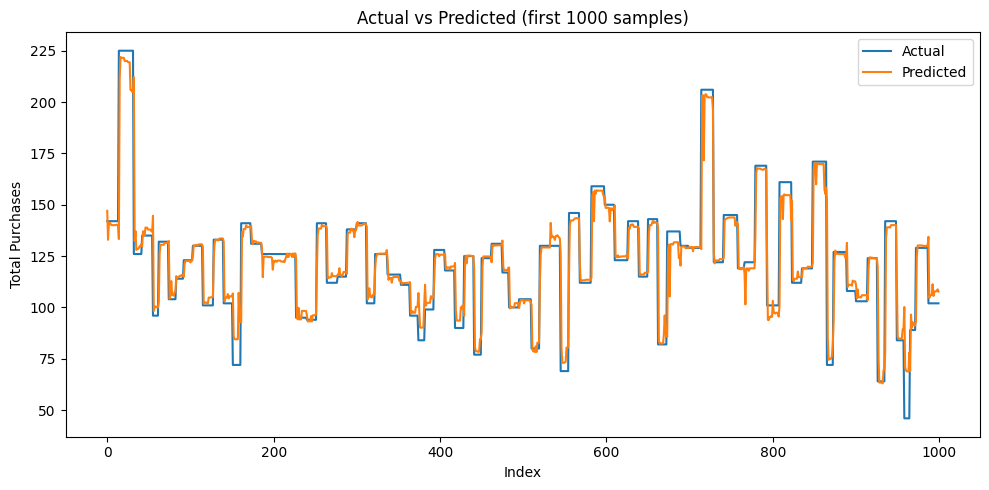

In [1]:
"""
LightGBM Model Training Script
Works with final_train_v3.csv and final_test_v3.csv

Produces:
 - model_lgbm.txt (LightGBM model)
 - lgbm_metrics.txt
 - feature_importance.csv
"""

import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pathlib import Path

TRAIN_PATH = Path("../data/final_train_v3.csv")
TEST_PATH = Path("../data/final_test_v3.csv")
MODEL_OUT = Path("../data/model_lgbm.txt")
METRIC_OUT = Path("../data/lgbm_metrics.txt")
FI_OUT = Path("../data/feature_importance.csv")

# -----------------------
# Load data
# -----------------------
print("Loading train/test...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# -----------------------
# Target
# -----------------------
TARGET = "Total_Purchases"

# Remove leakage columns
blacklist = ["Date", "products_grouped", "Product_Category", "Country"]

features = [c for c in train.columns if c not in blacklist + [TARGET]]

X_train = train[features]
y_train = train[TARGET]
X_test = test[features]
y_test = test[TARGET]

print(f"Training rows: {len(X_train)}, Test rows: {len(X_test)}")
print(f"Features used: {len(features)}")

# -----------------------
# LightGBM Dataset
# -----------------------
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# -----------------------
# LightGBM Parameters
# -----------------------
params = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 3,
    "min_data_in_leaf": 30,
    "verbose": -1
}

# -----------------------
# Train
# -----------------------
print("Training LightGBM...")
callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=50)
]

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    num_boost_round=2000,
    callbacks=callbacks
)


# -----------------------
# Predictions & Metrics + Accuracy + Plot

# -----------------------
print("Evaluating model...")
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
# Approximate accuracy metric
accuracy = max(0.0, 1 - (mae / (y_test.mean() + 1e-9)))
print(f"Accuracy (approx): {accuracy:.4f}")
rmse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

with open(METRIC_OUT, "w") as f:
    f.write(f"MAE: {mae}\nRMSE: {rmse}\n")

# -----------------------
# Actual vs Predicted Plot
# -----------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:1000], label='Actual')
plt.plot(preds[:1000], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (first 1000 samples)')
plt.xlabel('Index')
plt.ylabel('Total Purchases')
plt.tight_layout()
plt.savefig('../data/actual_vs_pred.png')

# -----------------------
# Feature Importance
# -----------------------
fi = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importance()
}).sort_values("importance", ascending=False)

fi.to_csv(FI_OUT, index=False)

# -----------------------
# Save Model
# -----------------------
model.save_model(str(MODEL_OUT))

print("LightGBM training complete ✔")
print(f"Saved model -> {MODEL_OUT}")
print(f"Saved metrics -> {METRIC_OUT}")
print(f"Saved feature importance -> {FI_OUT}")
